In [1]:
import pandas as pd
import numpy as np
from datetime import *
from impyute.imputation.cs import mice
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

### To add a column with count of distinct values mapped to values of other column
train['Unique_Health_Camp_per_patient']=train.groupby(['Patient_ID'])['Health_Camp_ID'].transform('nunique')

### Grouping one column and aggregating other columns differently
temp_df.groupby(['Name'], as_index=False).agg({'As': np.sum, 'Bs': np.sum,'Cs': np.sum})

### To convert 3 columns of year,month,day and converge to one
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
pd.to_datetime(df)

In [2]:
first_camp = pd.read_csv('First_Health_Camp_Attended.csv')
second_camp = pd.read_csv('Second_Health_Camp_Attended.csv')
third_camp = pd.read_csv('Third_Health_Camp_Attended.csv')
patient_details = pd.read_csv('Patient_Profile.csv')
camp_details = pd.read_csv('Health_Camp_Detail.csv')
train = pd.read_csv('Train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7


In [ ]:
train_ = 75,278
first_camp_ = 6,218
second_camp_ = 7,819
third_camp_ = 6,515
patient_details_ = 37,633
camp_details_ = 65

In [4]:
first_camp.head(2)

,Patient_ID,Health_Camp_ID,Donation,Health_Score
0,506181,6560,40,0.439024
1,494977,6560,20,0.097561


In [5]:
second_camp.head(2)

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700


In [6]:
third_camp.head(2)

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1


In [7]:
patient_details.head(2)

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry


In [8]:
camp_details.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2


### Feature Engineering

In [3]:
patient_details['social'] =  patient_details['Online_Follower'] + patient_details['LinkedIn_Shared'] + patient_details['Twitter_Shared'] + patient_details['Facebook_Shared']
patient_details = patient_details.iloc[:,[0,5,6,7,8,9,10,11]]

In [4]:
patient_details = patient_details.iloc[:,[0,1,2,3,4,7]]

In [5]:
train['Registration_Date'] = pd.to_datetime(train['Registration_Date'])

In [6]:
patient_details['Income'] = patient_details['Income'].replace(['None'], np.NaN)
patient_details['Education_Score'] = patient_details['Education_Score'].replace(['None'], np.NaN)
patient_details['Age'] = patient_details['Age'].replace(['None'], np.NaN)

In [7]:
patient_details['Income'] = patient_details['Income'].astype(np.float32)
patient_details['Age'] = patient_details['Age'].astype(np.float32)
patient_details['Education_Score'] = patient_details['Education_Score'].astype(np.float32)

In [8]:
train.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)

In [9]:
train

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
69348,485679,6578,2005-08-22,0,0,0,0,0
64479,485679,6555,2005-08-31,0,0,0,0,0
6484,485680,6543,2006-07-10,0,0,0,0,0
18999,485681,6580,2004-12-20,0,0,0,0,0
2604,485681,6526,2005-01-01,0,0,0,0,0
...,...,...,...,...,...,...,...,...
18124,528657,6531,2004-12-11,0,0,0,0,0
32744,528657,6580,2004-12-18,0,0,0,0,0
7632,528657,6526,2004-12-30,0,0,0,0,0
24471,528657,6536,2005-02-13,0,0,0,0,0


In [10]:
# Extracting Year, Month, Day in different columns; imputed missing values and then combining 3 columns to one as date

train['Registration_Date'] = pd.to_datetime(train['Registration_Date'])
train['year'] = train['Registration_Date'].dt.year
train['month'] = train['Registration_Date'].dt.month
train['day'] = train['Registration_Date'].dt.day

test['Registration_Date'] = pd.to_datetime(test['Registration_Date'])
test['year'] = test['Registration_Date'].dt.year.astype(np.float32)
test['month'] = test['Registration_Date'].dt.month.astype(np.float32)
test['day'] = test['Registration_Date'].dt.day.astype(np.float32)

In [12]:
train_date = train.iloc[:,[0,1,3,4,5,6,7,8,9,10]]
train_imputed = mice(train_date.values)
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_date.columns

test_imputed = test

In [13]:
train_imputed['year'] = train_imputed['year'].astype(int)
train_imputed['month'] = train_imputed['month'].astype(int)
train_imputed['day'] = train_imputed['day'].astype(int)

test_imputed['year'] = test_imputed['year'].astype(int)
test_imputed['month'] = test_imputed['month'].astype(int)
test_imputed['day'] = test_imputed['day'].astype(int)

In [14]:
train_imputed['Registration_Date'] = pd.DataFrame(pd.to_datetime(train_imputed[['year', 'month', 'day']]))
train_imputed.drop(['year', 'month', 'day'], axis=1, inplace = True)
train = train_imputed

test_imputed['Registration_Date'] = pd.DataFrame(pd.to_datetime(test_imputed[['year', 'month', 'day']]))
test_imputed.drop(['year', 'month', 'day'], axis=1, inplace = True)
test = test_imputed

### Data Manipulation

In [15]:
# Merging all camps
all_camps = pd.merge(first_camp, second_camp, on = ['Patient_ID', 'Health_Camp_ID'], how = 'outer')
all_camps = pd.merge(all_camps, third_camp, on = ['Patient_ID', 'Health_Camp_ID'], how = 'outer')
all_camps['output'] = 1
all_camps = all_camps.iloc[:,[0,1,7]]
all_camps.drop_duplicates(inplace = True)
all_camps.sort_values(by = ['Patient_ID', 'Health_Camp_ID'], inplace = True)
all_camps.head(2)

,Patient_ID,Health_Camp_ID,output
19629,485679,6578,1
13812,485682,6529,1


In [16]:
merged_train = pd.merge(train, patient_details, on = ['Patient_ID'], how = 'left')
merged_train = pd.merge(merged_train, camp_details, on = ['Health_Camp_ID'], how = 'left')
merged_train = pd.merge(merged_train, all_camps, on = ['Patient_ID','Health_Camp_ID'], how = 'left')
merged_train['output'].fillna(0, inplace = True)

merged_test = pd.merge(test, patient_details, on = ['Patient_ID'], how = 'left')
merged_test = pd.merge(merged_test, camp_details, on = ['Health_Camp_ID'], how = 'left')
merged_test = pd.merge(merged_test, all_camps, on = ['Patient_ID','Health_Camp_ID'], how = 'left')
merged_test['output'].fillna(0, inplace = True)

In [17]:
merged_train['Registration_Date'] = pd.to_datetime(merged_train['Registration_Date'])
merged_train['Camp_Start_Date'] = pd.to_datetime(merged_train['Camp_Start_Date'])
merged_train['Camp_End_Date'] = pd.to_datetime(merged_train['Camp_End_Date'])
merged_train['First_Interaction'] = pd.to_datetime(merged_train['First_Interaction'])

merged_test['Registration_Date'] = pd.to_datetime(merged_test['Registration_Date'])
merged_test['Camp_Start_Date'] = pd.to_datetime(merged_test['Camp_Start_Date'])
merged_test['Camp_End_Date'] = pd.to_datetime(merged_test['Camp_End_Date'])
merged_test['First_Interaction'] = pd.to_datetime(merged_test['First_Interaction'])

merged_train['start-regist'] = (merged_train['Camp_Start_Date'] - merged_train['Registration_Date']).dt.days.astype(np.int)
merged_train['end-start'] = (merged_train['Camp_End_Date'] - merged_train['Camp_Start_Date']).dt.days.astype(np.int)
merged_train['interact-start'] = (merged_train['First_Interaction'] - merged_train['Camp_Start_Date']).dt.days.astype(np.int)
merged_train['end-interact'] = (merged_train['Camp_End_Date'] - merged_train['First_Interaction']).dt.days.astype(np.int)
merged_train['end-regist'] = (merged_train['Camp_End_Date'] - merged_train['Registration_Date']).dt.days.astype(np.int)
merged_train['register-interact'] = (merged_train['Registration_Date'] - merged_train['First_Interaction']).dt.days.astype(np.int)

merged_test['start-regist'] = (merged_test['Camp_Start_Date'] - merged_test['Registration_Date']).dt.days.astype(np.int)
merged_test['end-start'] = (merged_test['Camp_End_Date'] - merged_test['Camp_Start_Date']).dt.days.astype(np.int)
merged_test['interact-start'] = (merged_test['First_Interaction'] - merged_test['Camp_Start_Date']).dt.days.astype(np.int)
merged_test['end-interact'] = (merged_test['Camp_End_Date'] - merged_test['First_Interaction']).dt.days.astype(np.int)
merged_test['end-regist'] = (merged_test['Camp_End_Date'] - merged_test['Registration_Date']).dt.days.astype(np.int)
merged_test['register-interact'] = (merged_test['Registration_Date'] - merged_test['First_Interaction']).dt.days.astype(np.int)

In [18]:
merged_train['register_year'] = merged_train['Registration_Date'].dt.year
merged_train['register_month'] = merged_train['Registration_Date'].dt.month
merged_train['register_day'] = merged_train['Registration_Date'].dt.day
merged_train['register_dayweek'] = merged_train['Registration_Date'].dt.dayofweek
merged_train['register_weekyear'] = merged_train['Registration_Date'].dt.weekofyear

merged_test['register_year'] = merged_test['Registration_Date'].dt.year
merged_test['register_month'] = merged_test['Registration_Date'].dt.month
merged_test['register_day'] = merged_test['Registration_Date'].dt.day
merged_test['register_dayweek'] = merged_test['Registration_Date'].dt.dayofweek
merged_test['register_weekyear'] = merged_test['Registration_Date'].dt.weekofyear

merged_train['start_year'] = merged_train['Camp_Start_Date'].dt.year
merged_train['start_month'] = merged_train['Camp_Start_Date'].dt.month
merged_train['start_day'] = merged_train['Camp_Start_Date'].dt.day
merged_train['start_dayweek'] = merged_train['Camp_Start_Date'].dt.dayofweek
merged_train['start_weekyear'] = merged_train['Camp_Start_Date'].dt.weekofyear

merged_test['start_year'] = merged_test['Camp_Start_Date'].dt.year
merged_test['start_month'] = merged_test['Camp_Start_Date'].dt.month
merged_test['start_day'] = merged_test['Camp_Start_Date'].dt.day
merged_test['start_dayweek'] = merged_test['Camp_Start_Date'].dt.dayofweek
merged_test['start_weekyear'] = merged_test['Camp_Start_Date'].dt.weekofyear

merged_train['end_year'] = merged_train['Camp_End_Date'].dt.year
merged_train['end_month'] = merged_train['Camp_End_Date'].dt.month
merged_train['end_day'] = merged_train['Camp_End_Date'].dt.day
merged_train['end_dayweek'] = merged_train['Camp_End_Date'].dt.dayofweek
merged_train['end_weekyear'] = merged_train['Camp_End_Date'].dt.weekofyear

merged_test['end_year'] = merged_test['Camp_End_Date'].dt.year
merged_test['end_month'] = merged_test['Camp_End_Date'].dt.month
merged_test['end_day'] = merged_test['Camp_End_Date'].dt.day
merged_test['end_dayweek'] = merged_test['Camp_End_Date'].dt.dayofweek
merged_test['end_weekyear'] = merged_test['Camp_End_Date'].dt.weekofyear

merged_train['interact_year'] = merged_train['First_Interaction'].dt.year
merged_train['interact_month'] = merged_train['First_Interaction'].dt.month
merged_train['interact_day'] = merged_train['First_Interaction'].dt.day
merged_train['interact_dayweek'] = merged_train['First_Interaction'].dt.dayofweek
merged_train['interact_weekyear'] = merged_train['First_Interaction'].dt.weekofyear

merged_test['interact_year'] = merged_test['First_Interaction'].dt.year
merged_test['interact_month'] = merged_test['First_Interaction'].dt.month
merged_test['interact_day'] = merged_test['First_Interaction'].dt.day
merged_test['interact_dayweek'] = merged_test['First_Interaction'].dt.dayofweek
merged_test['interact_weekyear'] = merged_test['First_Interaction'].dt.weekofyear

In [192]:
merged_train.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5',
       'Registration_Date', 'Income', 'Education_Score', 'Age',
       'First_Interaction', 'social', 'Camp_Start_Date', 'Camp_End_Date',
       'Category1', 'Category2', 'Category3', 'output', 'start-regist',
       'end-start', 'interact-start', 'end-interact', 'end-regist',
       'register-interact', 'register_year', 'register_month', 'register_day',
       'register_dayweek', 'register_weekyear', 'start_year', 'start_month',
       'start_day', 'start_dayweek', 'start_weekyear', 'end_year', 'end_month',
       'end_day', 'end_dayweek', 'end_weekyear', 'interact_year',
       'interact_month', 'interact_day', 'interact_dayweek',
       'interact_weekyear'],
      dtype='object')

In [19]:
merged_train_clean = merged_train.drop(['Registration_Date', 'First_Interaction', 'Camp_Start_Date', 'Camp_End_Date'], axis=1)
merged_test_clean = merged_test.drop(['Registration_Date', 'First_Interaction', 'Camp_Start_Date', 'Camp_End_Date'], axis=1)

In [20]:
merged_train_clean_OHE = merged_train_clean[['Category1', 'Category2']]
OHE = OneHotEncoder(sparse=False, drop='first')
merged_train_clean_OHE = OHE.fit_transform(merged_train_clean_OHE)
merged_test_clean_OHE = OHE.transform(merged_test_clean[['Category1', 'Category2']])

In [21]:
merged_train_clean_OHE = pd.DataFrame(merged_train_clean_OHE)
merged_train_clean_OHE.columns = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8']

merged_test_clean_OHE = pd.DataFrame(merged_test_clean_OHE)
merged_test_clean_OHE.columns = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8']

In [22]:
merged_train_clean = merged_train_clean.drop(['Category1', 'Category2'], axis = 1)
merged_test_clean = merged_test_clean.drop(['Category1', 'Category2'], axis = 1)

In [23]:
merged_train_clean_rejoin = pd.concat((merged_train_clean, merged_train_clean_OHE), axis = 1)
merged_test_clean_rejoin = pd.concat((merged_test_clean, merged_test_clean_OHE), axis = 1)

In [24]:
merged_train_clean_rejoin.head(2)

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,...,interact_dayweek,interact_weekyear,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8
0,485679.0,6578.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,4,32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,485679.0,6555.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,4,32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Imputing missing values of income, education and age
imputer = IterativeImputer()
merged_train_clean_imputed = imputer.fit_transform(merged_train_clean_rejoin)
merged_test_clean_imputed = imputer.transform(merged_test_clean_rejoin)

In [26]:
merged_train_clean_imputed1 = pd.DataFrame(merged_train_clean_imputed)
merged_train_clean_imputed1.columns = merged_train_clean_rejoin.columns

merged_test_clean_imputed1 = pd.DataFrame(merged_test_clean_imputed)
merged_test_clean_imputed1.columns = merged_test_clean_rejoin.columns
merged_test_clean_imputed1

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,...,interact_dayweek,interact_weekyear,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8
0,505701.0,6548.0,1.0,0.0,0.0,0.0,2.0,0.000000,74.916673,44.000000,...,2.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,500633.0,6584.0,0.0,0.0,0.0,0.0,0.0,1.000000,67.000000,41.000000,...,5.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,506945.0,6582.0,0.0,0.0,0.0,0.0,0.0,0.915351,75.849568,52.048339,...,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,497447.0,6551.0,0.0,0.0,0.0,0.0,0.0,0.000000,77.165547,47.000000,...,4.0,34.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,496446.0,6533.0,0.0,0.0,0.0,0.0,0.0,1.364998,77.391493,50.203349,...,1.0,38.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35244,507261.0,6525.0,12.0,2.0,0.0,0.0,6.0,1.000000,77.768713,37.000000,...,1.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
35245,513607.0,6551.0,0.0,0.0,0.0,0.0,0.0,1.472370,77.096391,49.300192,...,2.0,37.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35246,498160.0,6584.0,0.0,0.0,0.0,0.0,0.0,1.478654,76.094333,49.740008,...,4.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35247,502444.0,6567.0,0.0,0.0,0.0,0.0,0.0,1.452073,75.803286,50.044577,...,2.0,18.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
merged_train_clean_rejoin.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5',
       'Income', 'Education_Score', 'Age', 'social', 'Category3', 'output',
       'start-regist', 'end-start', 'interact-start', 'end-interact',
       'end-regist', 'register-interact', 'register_year', 'register_month',
       'register_day', 'register_dayweek', 'register_weekyear', 'start_year',
       'start_month', 'start_day', 'start_dayweek', 'start_weekyear',
       'end_year', 'end_month', 'end_day', 'end_dayweek', 'end_weekyear',
       'interact_year', 'interact_month', 'interact_day', 'interact_dayweek',
       'interact_weekyear', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6',
       'cat7', 'cat8'],
      dtype='object')

In [212]:
# merged_train_clean_rejoin_mice = mice(merged_train_clean_rejoin.values)
# merged_train_clean_rejoin_mice = pd.DataFrame(merged_train_clean_rejoin_mice)
# merged_train_clean_rejoin_mice.columns = merged_train_clean_rejoin.columns
# merged_train_clean_rejoin_mice

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,...,interact_dayweek,interact_weekyear,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8
0,485679.0,6578.0,0.0,0.0,0.0,0.0,0.0,1.121872,77.668297,50.311400,...,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,485679.0,6555.0,0.0,0.0,0.0,0.0,0.0,1.344786,77.904144,49.123680,...,4.0,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,485680.0,6543.0,0.0,0.0,0.0,0.0,0.0,0.751553,76.520387,52.378050,...,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,485681.0,6580.0,0.0,0.0,0.0,0.0,0.0,0.000000,77.067848,46.000000,...,6.0,51.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,485681.0,6526.0,0.0,0.0,0.0,0.0,0.0,0.000000,73.976730,46.000000,...,6.0,51.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75273,528657.0,6531.0,0.0,0.0,0.0,0.0,0.0,1.102133,77.334222,49.299071,...,0.0,44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75274,528657.0,6580.0,0.0,0.0,0.0,0.0,0.0,1.125748,76.067132,49.992960,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75275,528657.0,6526.0,0.0,0.0,0.0,0.0,0.0,1.239973,76.058311,49.466194,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75276,528657.0,6536.0,0.0,0.0,0.0,0.0,0.0,1.306794,75.728128,49.521379,...,0.0,44.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Visualization

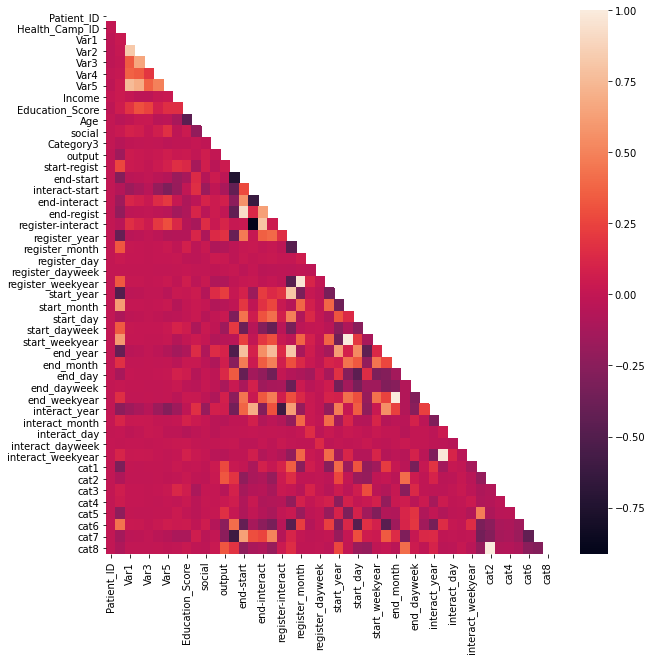

In [219]:
plt.figure(figsize=(10,10))
sns.heatmap(merged_train_clean_imputed.corr(), mask = np.triu(merged_train_clean_imputed.corr()))

# Model

### Random_forest

In [28]:
merged_test_clean_imputed1.drop(['output'], axis = 1, inplace = True)

In [29]:
X = merged_train_clean_imputed1.drop(['output'], axis = 1)
y = merged_train_clean_imputed1[['output']]

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [31]:
rf_clf = RandomForestClassifier(n_estimators=300)
rf_clf.fit(X_tr, y_tr)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
print(rf_clf.score(X_tr, y_tr))
print(rf_clf.score(X_val, y_val))

1.0
0.8983793836344315


In [255]:
(pd.DataFrame(rf_clf.predict_proba(merged_test_clean_imputed1))[[1]]).to_csv('predictions\\predicted1.csv', index = False)

In [ ]:
rf_clf.predict_proba(merged_test_clean_imputed1)

In [258]:
rf_clf.predict(X_val)

array([0., 1., 0., ..., 0., 0., 1.])

In [33]:
roc_auc_score(y_val, rf_clf.predict(X_val))

0.8528369296889966

### LightGBM

In [34]:
lgbm_clf = lgbm.LGBMClassifier(eval_metric = 'auc', n_estimators=300)

In [35]:
lgbm_clf.fit(X_tr, y_tr)

C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [36]:
print(lgbm_clf.score(X_tr, y_tr))
print(lgbm_clf.score(X_val, y_val))

0.9354981549815499
0.905154091392136


In [37]:
roc_auc_score(y_val, lgbm_clf.predict(X_val))

0.8627939117215954

In [340]:
(pd.DataFrame(lgbm_clf.predict_proba(merged_test_clean_imputed1))[[1]]).to_csv('predictions\\lgbm.csv', index = False)

### Neural Network

In [38]:
st_scale = StandardScaler() 
X_tr_nn = st_scale.fit_transform(X_tr)
X_val_nn = st_scale.transform(X_val)

In [39]:
X_tr_nn = torch.tensor(X_tr_nn)
X_val_nn = torch.tensor(X_val_nn)
y_tr_nn = torch.tensor(np.array(y_tr)).reshape(67750)
y_val_nn = torch.tensor(np.array(y_val)).reshape(7528)

In [ ]:
y_tr_nn = y_tr_nn.long()
y_val_nn = y_val_nn.int()

In [159]:
test_data = st_scale.transform(merged_test_clean_imputed1)
test_data = torch.tensor(test_data)
test_data

tensor([[-0.1225,  0.0194,  0.0277,  ..., -0.6216, -0.6977,  2.5197],
        [-0.5308,  1.8854, -0.1043,  ..., -0.6216, -0.6977, -0.3969],
        [-0.0223,  1.7817, -0.1043,  ..., -0.6216,  1.4332, -0.3969],
        ...,
        [-0.7301,  1.8854, -0.1043,  ..., -0.6216, -0.6977, -0.3969],
        [-0.3849,  1.0042, -0.1043,  ..., -0.6216, -0.6977, -0.3969],
        [ 1.3365,  1.8854,  0.4235,  ..., -0.6216, -0.6977, -0.3969]],
       dtype=torch.float64)

In [40]:
y_val_nn.shape

torch.Size([7528])

In [41]:
X_tr_nn.shape

torch.Size([67750, 46])

In [181]:
class HealthCareClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_z = nn.Linear(46,100)
        self.l1_a = nn.Tanh()
        self.l2_z = nn.Linear(100,100)
        self.l2_a = nn.Tanh()
        self.l3_z = nn.Linear(100,50)
        self.l3_a = nn.Tanh()
        self.l4_z = nn.Linear(50,20)
        self.l4_a = nn.Tanh()
        self.l5_z = nn.Linear(20,2)
        self.l5_a = nn.Softmax()

    def forward(self,x):
        z1 = self.l1_z(x)
        a1 = self.l1_a(z1)
        z2 = self.l2_z(a1)
        a2 = self.l2_a(z2)
        z3 = self.l3_z(a2)
        a3 = self.l3_a(z3)
        z4 = self.l4_z(a3)
        a4 = self.l4_a(z4)
        z5 = self.l5_z(a4)
        a5 = self.l5_a(z5)
        return a5

In [182]:
model = HealthCareClassifier()
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [217]:
for i in range(500):
    optimizer.zero_grad()
    output = model(X_tr_nn.float())
    loss = loss_fun(output, y_tr_nn)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 0.4656630754470825
1 0.4656592905521393
2 0.4656597673892975
3 0.4656544029712677
4 0.4656452536582947
5 0.4656391441822052
6 0.4656386971473694
7 0.46563801169395447
8 0.4656365215778351
9 0.4656323194503784
10 0.46561625599861145
11 0.4656023681163788
12 0.46558260917663574
13 0.4655787944793701
14 0.4655727744102478
15 0.46557044982910156
16 0.4655638635158539
17 0.46555817127227783
18 0.4655521810054779
19 0.4655495584011078
20 0.4655444324016571
21 0.46554291248321533
22 0.46554094552993774
23 0.4655369520187378
24 0.46552735567092896
25 0.4655272662639618
26 0.46552231907844543
27 0.4655188024044037
28 0.4655115008354187
29 0.4655061364173889
30 0.46550118923187256
31 0.4654998779296875
32 0.46549665927886963
33 0.4654935300350189
34 0.46548983454704285
35 0.46547824144363403
36 0.46547412872314453
37 0.4654681086540222
38 0.4654637277126312
39 0.4654622972011566
40 0.46545979380607605
41 0.46545761823654175
42 0.4654516875743866
43 0.4654417634010315
44 0.46543633937835693
45 

355 0.4646262228488922
356 0.4646262228488922
357 0.4646262228488922
358 0.4646262228488922
359 0.4646262228488922
360 0.46462616324424744
361 0.46462613344192505
362 0.46462613344192505
363 0.46462610363960266
364 0.4646260738372803
365 0.4646260738372803
366 0.4646260738372803
367 0.4646260738372803
368 0.4646260738372803
369 0.4646260738372803
370 0.4646260142326355
371 0.4646259844303131
372 0.4646259844303131
373 0.4646259546279907
374 0.4646259546279907
375 0.4646259546279907
376 0.4646259546279907
377 0.4646259546279907
378 0.4646259546279907
379 0.4646259546279907
380 0.4646259546279907
381 0.46462589502334595
382 0.46462586522102356
383 0.4646258056163788
384 0.4646258056163788
385 0.4646258056163788
386 0.4646258056163788
387 0.4646257758140564
388 0.464625746011734
389 0.464625746011734
390 0.464625746011734
391 0.464625746011734
392 0.4646257162094116
393 0.4646257162094116
394 0.46462568640708923
395 0.46462562680244446
396 0.46462559700012207
397 0.46462559700012207
398 0

In [218]:
# Prediction

print('Training_acc:',(torch.argmax(model(X_tr_nn.float()), dim = 1) == y_tr_nn).float().mean().item())
print('Validation_acc:',(torch.argmax(model(X_val_nn.float()), dim = 1) == y_val_nn).float().mean().item())

Training_acc: 0.8483690023422241
Validation_acc: 0.8347502946853638


C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [168]:
pd.DataFrame(model(test_data.float()).detach().numpy()).to_csv('MISC\\NN_proba.csv', index = False)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [160]:
pd.DataFrame(torch.argmax(model(test_data.float()), dim = 1)).to_csv('NN_1.csv', index = False)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [133]:
torch.save({'model':model,'model_state':model.state_dict()}, 'NN_95.pth')

In [45]:
print(X_tr_nn.shape)
print(X_val_nn.shape)
print(y_tr_nn.shape)
print(y_val_nn.shape)

torch.Size([67750, 46])
torch.Size([7528, 46])
torch.Size([67750])
torch.Size([7528])


In [46]:
print(X_tr_nn.dtype)
print(X_val_nn.dtype)
print(y_tr_nn.dtype)
print(y_val_nn.dtype)

torch.float64
torch.float64
torch.float64
torch.float64


In [224]:
predicted_X = np.delete(((model(X_val_nn.float())).detach().numpy()),0,1)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [225]:
predicted_X

array([[2.8779669e-07],
       [2.9609365e-07],
       [2.8853788e-07],
       ...,
       [2.9201675e-07],
       [2.8885506e-07],
       [9.9999952e-01]], dtype=float32)

In [216]:
pd.DataFrame(predicted_X).to_csv('MISC\\temp.csv', index = False)

In [228]:
roc_auc_score(y_val_nn, predicted_X)

0.8236204541260296

In [196]:
(model(X_val_nn.float())[1]).detach().numpy()

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([9.9999917e-01, 8.9233077e-07], dtype=float32)